<div class="alert alert-warning">

**Disclaimer:**

This notebook is not maintained. The functionality presented here is not guaranteed to work with the latest version of eo-learn. External data is also required to run this notebook. 
</div>

# Poverty detection with machine learning from space

In this study, we hope to use satellite image spectral bands and image features to separate neighborhoods from the poorest to richest in Rwanda. For specific methodology, we are going to use **transfer learning** from a pre-trained Convolutional Neural Network. The pre-trained model is VGG16, and of course, you can switch to other neural net architectures. 

**Hypothesis**

People in the more impoverished neighborhoods in Rwanda are:

- living in smaller houses in dense residential areas;
- less accessibility from main road networks;
- less green space;
- more unpaved area;
- drier, with less running and drinking water.
- less night time activities which is reflected in nightlight imagery with dimmer light at night.

Theses features for identifying poverty can change by country, region, and continent. We suggest you do thorough research before you make similar hypotheses in your study area.  For this exercise, we queried three data sources for the study: Sentinel-2A, SNP VIIRS night-time lights, and the USAID DHS household survey. The workflow to query and extract the data sources is shown below in a  simplified diagram.

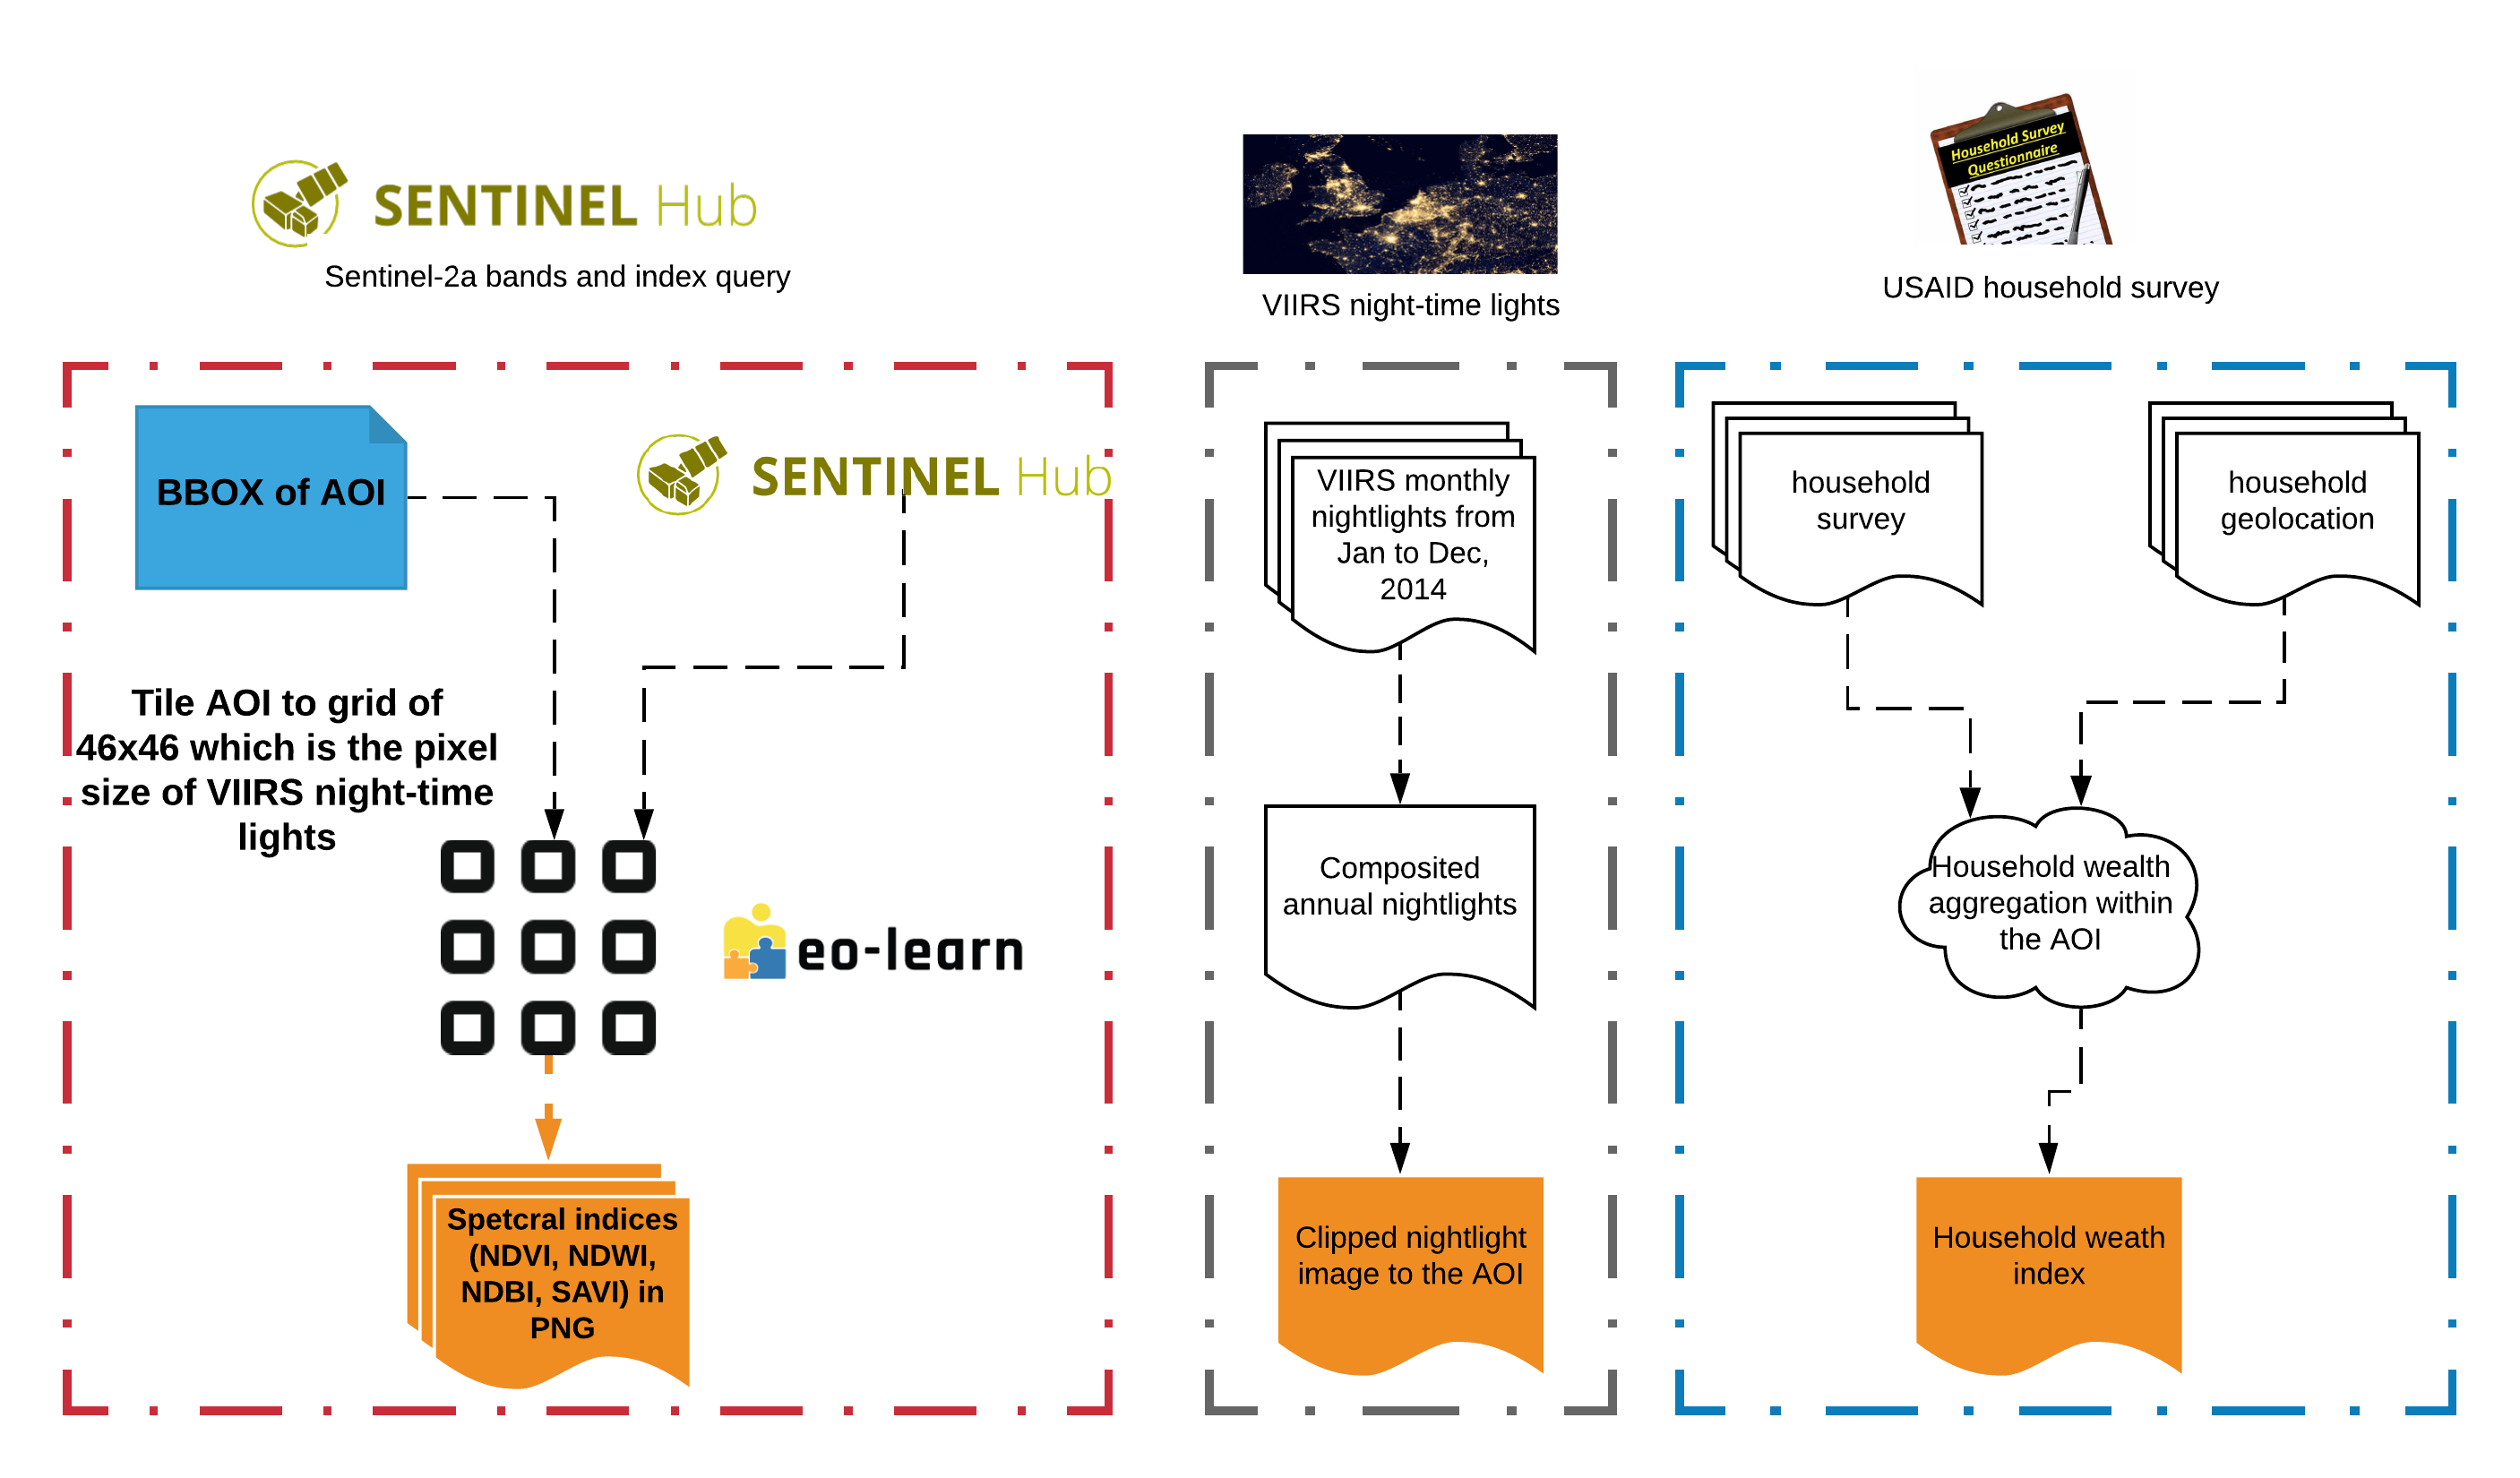

In [3]:
from IPython.display import Image
from os import path as op
Image(op.join(root_dir, 'figures/poverty_detection_data_sources.png'))

In [17]:
%matplotlib inline

import os, shutil, glob, random
from os import makedirs, path as op
from shutil import copyfile
from random import shuffle
from time import time
import json
from tqdm import tqdm_notebook as tqdm

import numpy as np
import numpy.ma as ma 
import geopandas as gpd

# satellite imagery manipulation
from sentinelhub import BBoxSplitter, CRS, DataCollection, SHConfig

from eolearn.core import EOTask, FeatureType, SaveTask, AddFeature, OverwritePermission, LinearWorkflow, EOPatch, EOExecutor, LoadTask
from eolearn.io import ExportToTiff, SentinelHubInputTask
from eolearn.mask import AddValidDataMaskTask
from eolearn.features import LinearInterpolation, SimpleFilterTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask

# visualization
import matplotlib.pyplot as plt
from rasterio.plot import show
import seaborn as sns
import fiona

# image croping and creating geojson
import rasterio
import rasterio.mask
from rasterio.plot import show_hist
from rasterio.features import rasterize
from rasterio.warp import calculate_default_transform, reproject, Resampling
import shapely
from shapely.geometry import mapping, shape, Polygon
from rasterio.windows import Window, bounds as wind_bounds
from rasterio.warp import transform_bounds


from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

#extract raster stats from nightlights
import rasterstats as rs
from PIL import Image
import pandas as pd


## Getting data together

**Data source 1: Sentinel-2 from SentinelHub**

- NDVI - vegetation index- reflects the greenness of the neighborhood.
- NDWI - water index - wetness, running and drinking water.
- NDBI - built-up index - manmade built-up area and neighborhood pavement.

**Data source 2: VIIRS nightlight**

VIIRS nighttime lights imagery that has been distributed since 2012 by The Earth Observations Group (EOG) at NOAA/NGDC, and is produced as monthly or annual averages. The data is available as mosaics that have been post-processed (i.e., to remove clouds, stray light, and lunar illumination).

**Data source 3: DHS household survey**

The Demographic and Health Surveys (DHS) is a program lead by USAID to collect, analyze, and disseminate accurate and representative data on population, health, HIV and nutrition through over 90 countries. In this study, we are going to use the DHS household survey and associated household GPS from Rwanda. **Be mindful that you will need to request DHS datasets to the DHS program**, and it may take a few days to get access to the data. 


The following three cells show general datasets for the poverty detection workflow. The datasets include the country boundary and areas of interest (AOI) for the model training and testing. 

In [ ]:
country = op.join(root_dir, "geopolygons/RWA_adm0.shp") # country boundary of Rwanda
train_aoi = op.join(root_dir, "geopolygons/super_small_rwanda_aoi.geojson") # area of interest to train VGG16 later 
inference_aoi = op.join(root_dir, "geopolygons/rwanda_test_aoi.geojson") # area of interest to test how a transfer learned model perform
t_crs = "EPSG:32736" # target projection for Rwanda
time_interval = ['2015-01-01', '2015-12-31'] # Sentinel-2a data available from 2015, but our DHS data is from 2014

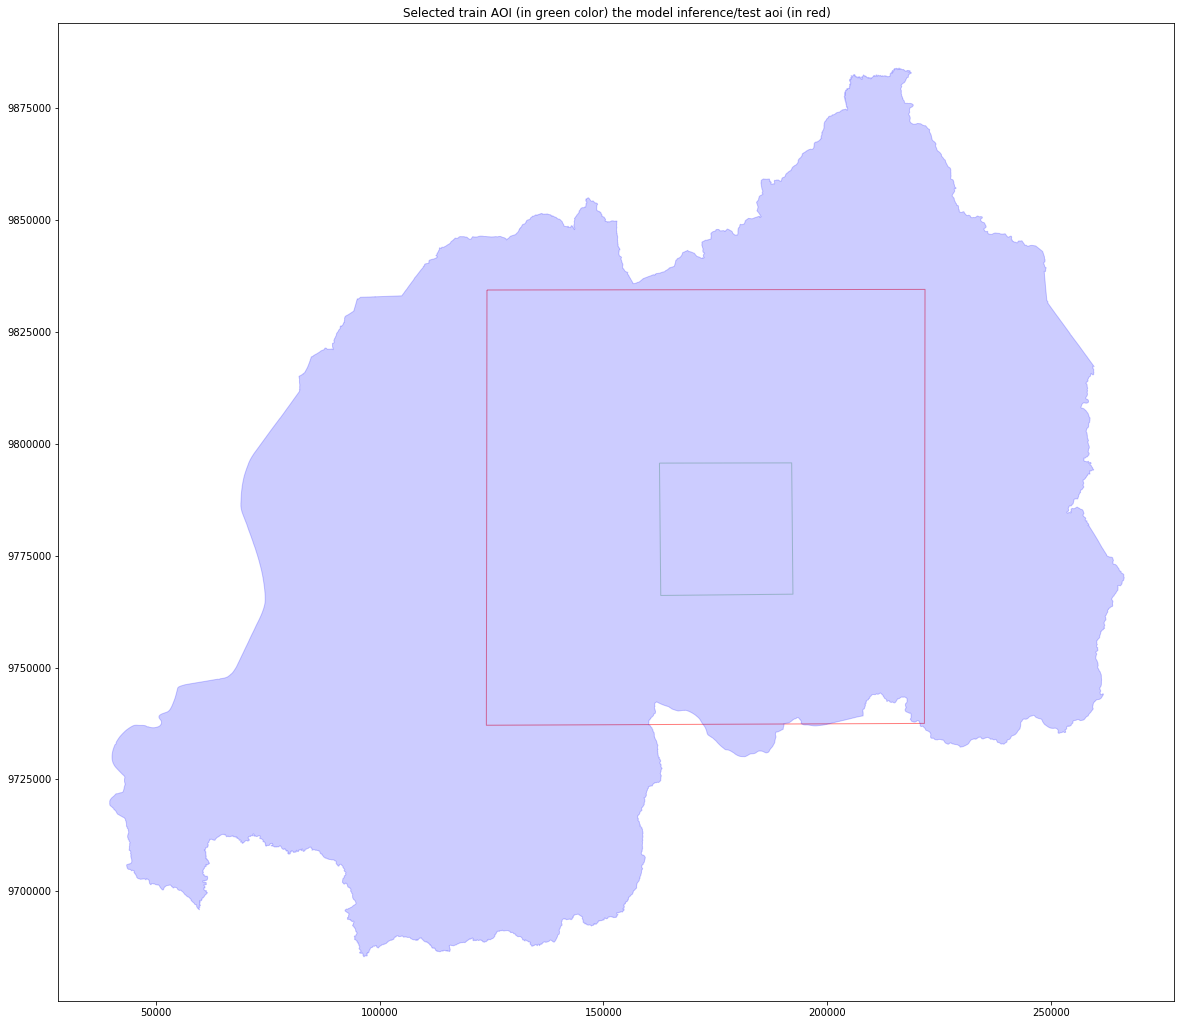

In [6]:
country_polyg = gpd.read_file(country)
train_polyg = gpd.read_file(train_aoi)
test_polyg = gpd.read_file(inference_aoi)

#reproject the polygons to the target projection
country_polyg = country_polyg.to_crs(crs=t_crs.pyproj_crs())
train_polyg = train_polyg.to_crs(crs=t_crs.pyproj_crs())
test_polyg = test_polyg.to_crs(crs=t_crs.pyproj_crs())

fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 18}

fig, ax = plt.subplots(figsize=(20, 20))
train_polyg.plot(ax = ax, facecolor = 'w', edgecolor = 'g', alpha = 0.5) # training aoi in green
test_polyg.plot(ax = ax, facecolor = 'w', edgecolor = 'r', alpha = 0.5) # inference/test aoi in red
country_polyg.plot(ax =ax, facecolor='b', edgecolor='b', alpha = 0.2) # Rwanda
ax.set_title('Selected train AOI (in green color) the model inference/test aoi (in red)');

### SNPP VIIRS night-time light intensity extraction

**Note**: Sentinel-2 indices will be saved as `EOPatch`es. To familiarize yourself with the `EOPatch` concept, please read [the documentation of eo-learn](https://eo-learn.readthedocs.io/en/latest/examples/core/CoreOverview.html#EOPatch). We designed the patch grid size so that it is equal to the VIIRS nightlight pixel size. Doing so will simplify the training dataset construction when we train a neural net in the following section of the workflow.

We will work with the VIIRS nightlight first, and use the nightlight image to reconstruct eopatch for later model training. 

In [ ]:
# We've composited monthly VIIRS nightlights into annual nightlights for a tile that covers Rwanda
# if you want to learn where and how to get the VIIRS nightlight data, you can visit this link:
# https://ngdc.noaa.gov/eog/viirs/download_dnb_composites.html
nl = op.join(root_dir, "annual_00N060W_2014.tif" )
geo_fname = op.splitext(train_aoi.split("/")[-1])[0]
year = 2014
fout ='{}_{}.tif'.format(geo_fname, year)
with fiona.open(train_aoi, "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]

with rasterio.open(nl) as src:
    out_image, out_transform = rasterio.mask.mask(src, features,
                                                        crop=True)
    out_meta = src.meta.copy()
    out_image.astype(np.int8)
    
#  output the clipped nightlights images for the training aoi
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open(op.join(root_dir, fout), "w", **out_meta) as dest:
    dest.write(out_image)

In [ ]:
# reproject nightlights 
with rasterio.open(op.join(root_dir, fout)) as src:
    transform, width, height = calculate_default_transform(
            src.crs, t_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
            'crs': t_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

    nm_fout = fout.split("/")[-1]
    with rasterio.open(op.join(root_dir,'reproj_{}'.format(nm_fout)), 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=t_crs,
                resampling=Resampling.nearest)

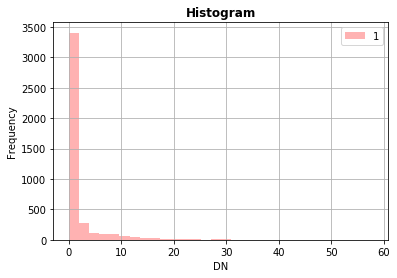

In [9]:
# visualize the nightlight intensity values
show_hist(out_image, bins=30, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram")

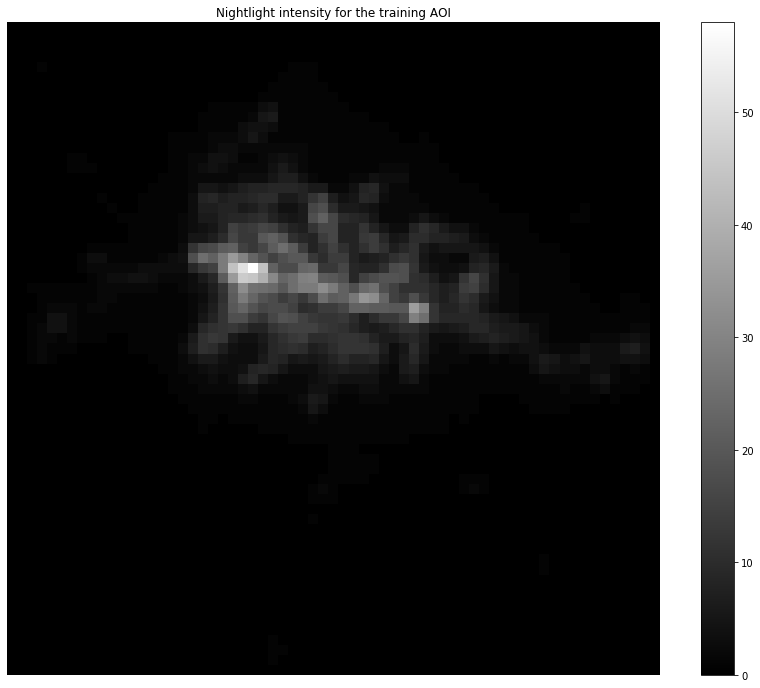

In [10]:
# nightlight intensity visualization, the training area is located around Rwanda's captial
nl_2014_train = rasterio.open(op.join(root_dir, "super_small_rwanda_aoi_2014.tif")).read(1)
fig, ax = plt.subplots(figsize=(15,12))
ndvi = ax.imshow(nl_2014_train, cmap='gist_gray')
fig.colorbar(ndvi)
ax.set(title='Nightlight intensity for the training AOI')
ax.set_axis_off();

### Construction of Sentinel-2 image indices from SentinelHub 

In [ ]:
def create_grids(nl_lights, t_crs, grid_sz = 46):
    """
    Loop through nightlight pixels in the geotif to create grid cells. 
    
    ---
    Param
    
    nl_lights: geotif of nightlight of the training area;
    t_crs: target CRS for the grid cell
    grid_sz: grid cell size.
    
    Return
    patchIDs: patch ID to collect sentinel-2 imagery from SentinelHub
    tile_list: EOpatch that contain boundbox of grid cell to fetch Sentinel-2 spectral information
    
    """
    gpd_geo = list()
    prop = list()
    tile_lists = list()
    # loop through each row and column of nightlight pixel to creat bounding box
    with rasterio.open(nl_lights) as src_dst:
        for col_off in range(0, src_dst.width):
            for row_off in range(0, src_dst.height):
                bounds = wind_bounds(Window(col_off, row_off, 1, 1), src_dst.transform)
                xmin, ymin, xmax, ymax = transform_bounds(
                    *[src_dst.crs, "epsg:4326"] + list(bounds), densify_pts=21
                )
                poly = shapely.geometry.Polygon([
                    (xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)
                ])
                gpd_geo.append(poly)
                prop.append("{}_{}".format(col_off, row_off))
    gpd_df = gpd.GeoDataFrame(prop, crs=CRS.WGS84.pyproj_crs(), geometry=gpd_geo)
    gpd_reproj = gpd_df.rename(columns={0: "id", "geometry": "geometry"})
    gpd_reproj = gpd_reproj.to_crs(crs=t_crs.pyproj_crs())
    designed_bbox_shapes = gpd_reproj.geometry.tolist()
    for aoi_shape in designed_bbox_shapes:
        width_pix = int((aoi_shape.bounds[2] - aoi_shape.bounds[0])/10)
        heigth_pix = int((aoi_shape.bounds[3] - aoi_shape.bounds[1])/10)

        width_grid = int(round(width_pix/grid_sz))
        heigth_grid =  int(round(heigth_pix/grid_sz))

        # split the tile grid by the desired grid number
        tile_splitter = BBoxSplitter([aoi_shape], t_crs, (width_grid, heigth_grid))

        tile_list = np.array(tile_splitter.get_bbox_list())
        info_list = np.array(tile_splitter.get_info_list())

        # get the all pylogon information from the splitted AOI
        idxs_x = [info['index_x'] for info in tile_splitter.info_list]
        idxs_y = [info['index_y'] for info in tile_splitter.info_list]
        tile_lists.append(tile_list)

    tile_list = np.array(tile_lists).flatten()
    return tile_list

In [ ]:
# we know that VIIRS pixel size is 462m.
# with 10m resolution of Sentinel-2, 46 by 46 pixel will cover a pixel of nightlight
tile_list = create_grids(op.join(root_dir, fout), t_crs)

In [14]:
"""
Getting valid sentinel-2 dataset from SentinelHub

Script adopted from eo-learn land-cover-map example:
https://github.com/sentinel-hub/eo-learn/tree/master/examples/land-cover-map

"""

class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `dataMask` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['dataMask'].astype(np.bool), 
                              np.logical_not((eopatch.mask['CLM'] != 0).astype(np.bool)))

class CountValid(EOTask):
    """counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))

        return eopatch


class NormalizedDifferenceIndex(EOTask):
    """
    Defined Normalised Difference Index (NDI) between two bands A and B as:
    NDI = (A-B)/(A+B).
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])

    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]

        ndi = (band_a - band_b) / (band_a  + band_b)

        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[..., np.newaxis])

        return eopatch

class ConcatenateData(EOTask):
    """Task to concatenate data arrays along the last dimension"""
    def __init__(self, feature_name, feature_names_to_concatenate):
        self.feature_name = feature_name
        self.feature_names_to_concatenate = feature_names_to_concatenate

    def execute(self, eopatch):
        arrays = [eopatch.data[name] for name in self.feature_names_to_concatenate]

        eopatch.add_feature(FeatureType.DATA, self.feature_name, np.concatenate(arrays, axis=-1))

        return eopatch


class ValidDataFractionPredicate:
    """Predicate that defines if a frame from EOPatch's time-series is valid or not.
    Frame is valid, if the valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold


In [ ]:
# fetch the Eopatch IDs along with tiles list from the input AOI for training

print("Extracting the dataset from SentinelHub with eo-learn")
# TASK FOR BAND DATA
# add a request for B(B02), G(B03), R(B04), NIR (B08), SWIR1(B11), SWIR2(B12)
# from default layer 'ALL_BANDS' at 10m resolution
# Here we also do a simple filter of cloudy scenes. A detailed cloud cover
# detection is performed in the next step
custom_script = 'return [B03, B04, B08, B11];'
add_data = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L1C,
    bands=['B03', 'B04', 'B08', 'B11'],
    bands_feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    additional_data=[(FeatureType.MASK, 'dataMask'), (FeatureType.MASK, 'CLM'), (FeatureType.DATA, 'CLP')],
    resolution=(10,10),
    maxcc=0.99, # maximum allowed cloud cover of original ESA tiles
)
#[ B03, B04, B08, B11], which corresponds to [G, R, NIR, SWIR1]

# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NDBI: (B11 - B08)/(B11 + B08)

ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/2', 'BANDS/1')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/0', 'BANDS/2')
ndbi = NormalizedDifferenceIndex('NDBI', 'BANDS/3', 'BANDS/2')
# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(),
                                      valid_data_feature='IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

# TASK FOR CONCATENATION
concatenate = ConcatenateData('FEATURES', ['NDVI', 'NDWI', 'NDBI'])
# TASK FOR FILTERING OUT TOO CLOUDY SCENES
# keep frames with > 99 % valid coverage
valid_pixels = 0.99
valid_data_predicate = ValidDataFractionPredicate(valid_pixels)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# TASK FOR LINEAR INTERPOLATION
# linear interpolation of full time-series and date resampling every month
resampling = 30
resampled_range = (time_interval[0], time_interval[1], resampling)
linear_interp = LinearInterpolation(
    'FEATURES', # name of field to interpolate
    mask_feature=(FeatureType.MASK, 'IS_VALID'), # mask to be used in interpolation
    resample_range=resampled_range # set the resampling range
)
path_out_sampled =  op.splitext(train_aoi.split("/")[-1])[0]
if not op.isdir(path_out_sampled):
    makedirs(op.join(root_dir, path_out_sampled))
save = SaveTask(path_out_sampled, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)
workflow = LinearWorkflow(
        add_data,
        ndvi,
        ndwi,
        ndbi,
        add_sh_valmask,
        count_val_sh,
        concatenate,
        filter_task,
        linear_interp,
        save)

In [18]:
# configure SentinelHub client and secret for OAuth access
# see: https://sentinelhub-py.readthedocs.io/en/latest/configure.html#sentinel-hub-configuration

config = SHConfig()

if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")

In [ ]:
# The following cell will download Sentinel-2 indices as (46 x 46 pixels) eopatch
# and save them under a foler called 'rwanda_test_aoi' 
# if you don't have a valid Instance ID, we've downloaded dataset and saved them as PNGs in 'train', 'validation' and 'test'
# you can skip the following cell and go to 'Train VGG16' section in this notebook directly.

for idx, bbox in enumerate(tqdm(tile_list)):
    execution_args = {
        add_data:{'bbox': bbox, 'time_interval': time_interval},
        save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    }
    workflow.execute(execution_args)

### DHS household wealth index extraction


In [16]:
# data is pretty big and will take a while to read in
df_path = op.join(root_dir, "RWHR70DT/RWHR70FL.DTA")

# if get utif8 erro using "rb" to read 
with open(df_path, "rb") as f:
    df = pd.read_stata(f)
df.head()

,hhid,hv000,hv001,hv002,hv003,hv004,hv005,hv006,hv007,hv008,hv009,hv010,hv011,hv012,hv013,hv014,hv015,hv016,hv017,hv018,hv019,hv020,hv021,hv022,hv023,hv024,hv025,hv026,hv027,hv028,hv030,hv031,hv032,hv035,hv040,hv041,hv042,hv044,hv201,hv202,...,hvc51_1,hvc51_2,hvc51_3,hvc51_4,hvc51_5,hvc51_6,hvc51_7,hvc51_8,hvc60_1,hvc60_2,hvc60_3,hvc60_4,hvc60_5,hvc60_6,hvc60_7,hvc60_8,hvc61_1,hvc61_2,hvc61_3,hvc61_4,hvc61_5,hvc61_6,hvc61_7,hvc61_8,hvc62_1,hvc62_2,hvc62_3,hvc62_4,hvc62_5,hvc62_6,hvc62_7,hvc62_8,hvc68_1,hvc68_2,hvc68_3,hvc68_4,hvc68_5,hvc68_6,hvc68_7,hvc68_8
0,1 1,RW6,1,1,1,1,1003964,11,2014,1379,6,1,0,6,6,1,completed,15,1,41,1,all woman sample,1,huye - rural,huye - rural,south,rural,NaN,not selected,0,41,42,1,1,1776,1,selected,NaN,public tap/standpipe,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1 2,RW6,1,2,1,1,1003964,11,2014,1379,3,1,1,3,3,0,completed,17,1,47,1,all woman sample,1,huye - rural,huye - rural,south,rural,NaN,men's survey,1003668,41,42,1,0,1776,2,not selected,household selected,public tap/standpipe,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1 3,RW6,1,3,1,1,1003964,11,2014,1379,1,0,0,1,1,0,completed,18,1,46,1,all woman sample,1,huye - rural,huye - rural,south,rural,NaN,not selected,0,41,42,1,0,1776,0,selected,NaN,public tap/standpipe,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1 4,RW6,1,4,1,1,1003964,11,2014,1379,5,4,0,5,5,0,completed,17,1,45,1,all woman sample,1,huye - rural,huye - rural,south,rural,NaN,men's survey,1003668,41,42,1,0,1776,4,not selected,household selected,public tap/standpipe,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not in household,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1 5,RW6,1,5,1,1,1003964,11,2014,1379,4,1,0,4,4,2,completed,15,1,45,1,all woman sample,1,huye - rural,huye - rural,south,rural,NaN,not selected,0,41,42,1,2,1776,1,selected,NaN,public tap/standpipe,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# From the above data frame, we only need three columns to reconstruct household wealth index
# For more information you can read DHS documentation on how the household wealth was calculated
# website: https://www.dhsprogram.com/topics/wealth-index/Wealth-Index-Construction.cfm

wealth = df[['hv001','hv270','hv271']]
cluster_avg_asset = wealth.groupby('hv001')['hv271'].median().reset_index()
# There are 492 unique household survey in Rwanda
len(cluster_avg_asset)

492

In [18]:
# read in geolocations of household so we can map them 

gdf_RW = gpd.read_file(op.join(root_dir, "RWGE72FL/RWGE72FL.shp"))
gps = gdf_RW[['DHSCLUST', 'URBAN_RURA', 'LATNUM', 'LONGNUM']] # only selected a few columns from the dataset
#join the household data with its geolocation information
result = cluster_avg_asset.merge(gps, how='inner', left_on='hv001', right_on='DHSCLUST')[['hv001', 'hv271','URBAN_RURA', 'LATNUM', 'LONGNUM']]
# assign wealth index to the household
result['wealth_Index'] = result['hv271']/10000
result.head()

,hv001,hv271,URBAN_RURA,LATNUM,LONGNUM,wealth_Index
0,1,29967.0,R,-2.505926,29.712786,2.99670
1,2,-44330.5,R,-1.844667,30.310508,-4.43305
2,3,-46276.5,R,-1.841935,29.574756,-4.62765
3,4,-54063.5,R,-2.348161,30.463639,-5.40635
4,5,-20998.0,R,-2.211301,30.161839,-2.09980


In [ ]:
# the output geojson file need to reproject to a same CRS with other dataset, especially nightlight
geo_result = gpd.GeoDataFrame(
    result,
    geometry=gpd.points_from_xy(result.LONGNUM, result.LATNUM),
    crs=CRS.WGS84.pyproj_crs()
)

result_repro = geo_result.to_crs(crs=t_crs.pyproj_crs())

## Poverty detection with a pre-trained CNN


Before we do an actual poverty detection, we went through two-critical steps. We recommend you do so too particularly if you want to move this exercise to a new country or region beyond Rwanda.

**Step 1. Building a correlation between nightlight intensity and household wealth index**


**Step 2. Building poverty detection with Sentinel-2 indices and nightlight intensity using pre-trained VGG16**


### Step 1. Building a correlation between nightlight intensity and household


The household wealth index was extracted and reconstructed from the DHS dataset. For details on how it was calculated, you can see the following scripts. 

DHS is hard and expensive to collect. It also covers a limited geospatial region. However, nightlight intensity values can be extracted from VIIRS nightlight and it's global coverage. The purpose of this step is to find a correlation between nightlight intensity and household wealth index. 

If we can find the correlation, the nightlight intensity values can be a proxy of the household wealth index. That covers landscape at a more granular level to train a machine learning model using nightlight intensity instead of relying on the DHS household survey. Such a trained model can be scaled up, and validated with night-time light intensity when a DHS household wealth index is not available for poverty detection.

In [ ]:
# we will rank the household wealth index into 5 categories
# from poorest to richest.
ranks = [i for i in range(5)]
bins = [-80720, -36535, 0, 36246, 155870, 349092]
result_repro['rank'] = pd.cut(result_repro['hv271'], bins, labels=ranks)

The following map shows the household survey and wealth categories in Rwanda. The richer neiborhoods are located in urban areas. The map was generated from QGIS.

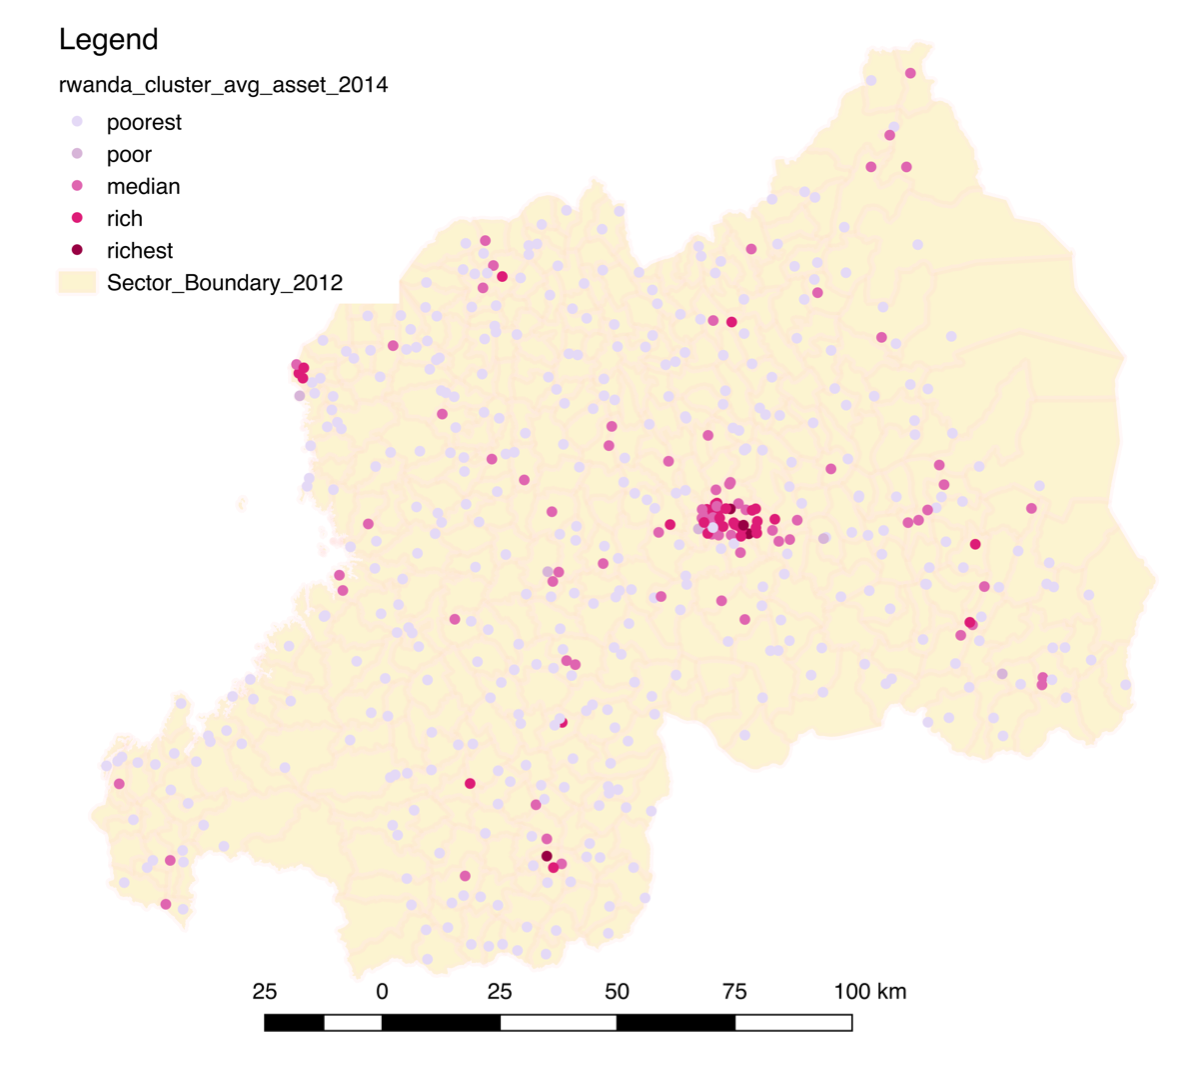

In [21]:
from IPython.display import Image
Image(op.join(root_dir, 'figures/dhs_household_wealth.png'))

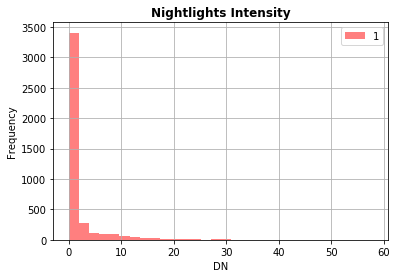

In [22]:
# read in the nightlight for the whole Rwanda to match the household survey data
nl_2014_raw = rasterio.open(op.join(root_dir,'reproj_{}'.format(nm_fout)))
nl_2014 = nl_2014_raw.read(1)
show_hist(nl_2014_raw, bins = 30, lw = 1, alpha = 0.5, title="Nightlights Intensity")

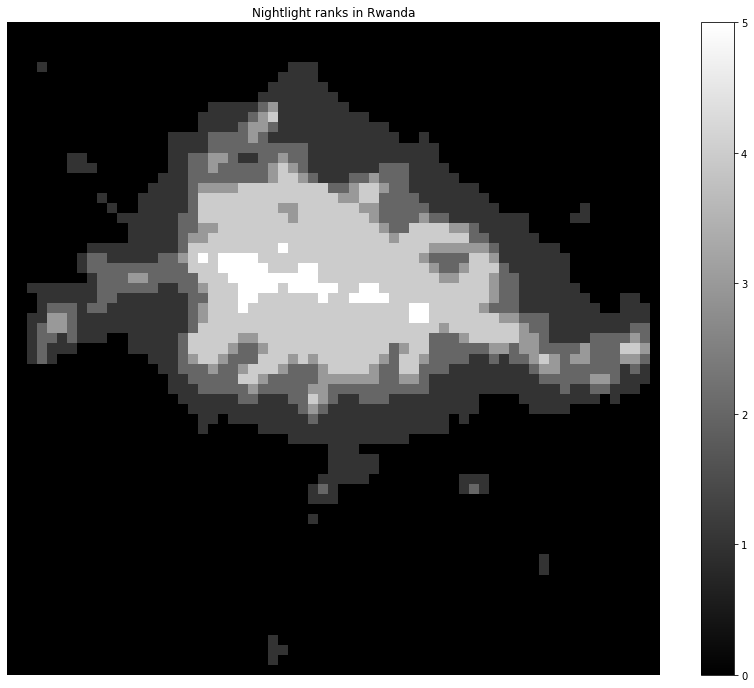

In [23]:
# devided nightlight into five categories
nl_bins = [0, 1, 3, 5,  22, 492]
# map the nightlight intensity into five categories
new_nl = np.digitize(nl_2014, nl_bins, right=True)
# need to add a colorbar to this image
fig, ax = plt.subplots(figsize=(15,12))
nlv = ax.imshow(new_nl, cmap='gist_gray')
fig.colorbar(nlv, fraction=.05)
ax.set(title="Nightlight ranks in Rwanda")
ax.set_axis_off();

In [ ]:
# Create a buffered polygon layer for the surveyed household location
result_repro_ = result_repro.copy()

# 1km buffered geometry
result_repro_["geometry"] = result_repro_.geometry.buffer(1000, cap_style=3)

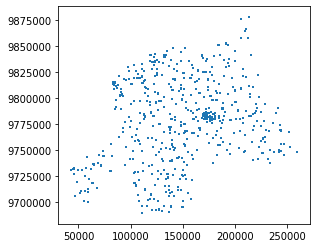

In [25]:
# show the household buffer on the map
result_repro_.plot()

In [30]:
# household wealth index
result_repro_.head()

,hv001,hv271,URBAN_RURA,LATNUM,LONGNUM,wealth_Index,geometry,rank
0,1,29967.0,R,-2.505926,29.712786,2.99670,"POLYGON ((135361.617 9723559.127, 135361.617 9...",2
1,2,-44330.5,R,-1.844667,30.310508,-4.43305,"POLYGON ((201770.513 9796881.968, 201770.513 9...",0
2,3,-46276.5,R,-1.841935,29.574756,-4.62765,"POLYGON ((119823.547 9797043.583, 119823.547 9...",0
3,4,-54063.5,R,-2.348161,30.463639,-5.40635,"POLYGON ((218909.471 9741200.253, 218909.471 9...",0
4,5,-20998.0,R,-2.211301,30.161839,-2.09980,"POLYGON ((185287.725 9756281.680, 185287.725 9...",1


In [ ]:
affine = nl_2014_raw.transform

In [ ]:
dhs_nl = rs.zonal_stats(result_repro_,
                        new_nl,
                        affine= affine,
                        geojson_out=True,
                        copy_properties=True,
                        stats=["mean", 'std'])

In [ ]:
dhs_nl_new = rs.zonal_stats(gpd.GeoDataFrame(result_repro_),
                        nl_2014,
                        affine= affine,
                        geojson_out=True,
                        copy_properties=True,
                        stats=["median"])

In [ ]:
# create a geo-dataframe for nightlight and household wealth so we can run some regression to find some correlation
geometry = [shape(feat["geometry"]) for feat in dhs_nl]
props = [feat["properties"] for feat in dhs_nl]
result = gpd.GeoDataFrame(props, crs=t_crs.pyproj_crs(), geometry=geometry)
result['wealth_idx'] = result['hv271'] / 100000

(0, 5)

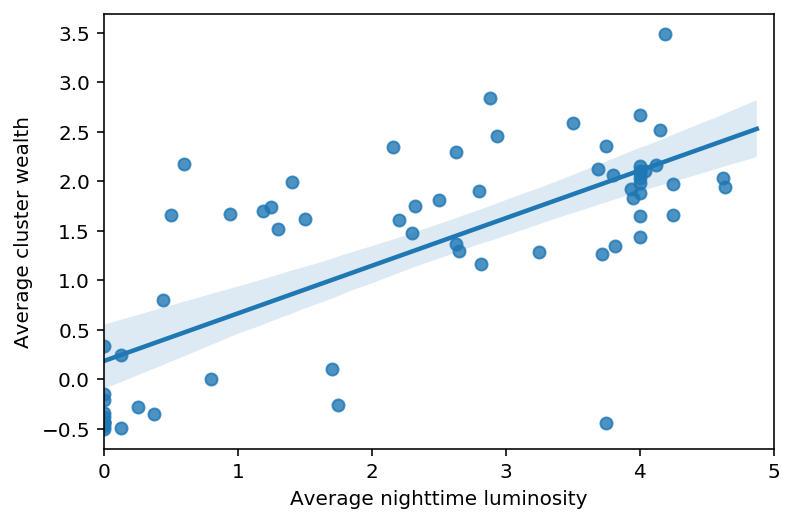

In [67]:
%config InlineBackend.figure_format = 'retina'
data = result.dropna() 
ax = sns.regplot(x="mean", y="wealth_idx", data=data)
plt.xlabel('Average nighttime luminosity')
plt.ylabel('Average cluster wealth')
plt.xlim([0, round(max(data['mean']))])

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

reproj = clean_dataset(result[['mean', 'std', 'rank']])
df_stats = reproj[['mean','std', 'rank']].as_matrix()

In [ ]:
np.random.seed(123)

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(df_stats):
        clf = LogisticRegression()
        train = df_stats[train_index]
        test = df_stats[test_index]
        clf.fit(train[:, :-1], train[:, -1])
        s = clf.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

In [70]:
print('R^2 of the best model: {:.3f}'.format(np.max(final)))

R^2 of the best model: 0.674


**Note**: The R<sup>2</sup> between nightlight intensity and household wealth is **0.674**. The correlation is considered statistically significant, so we are going to move to the next step, which is to build a neural net between nightlight and sentinel-2 indices. 

### Step 2. Building poverty detection with Sentinel-2 indices and nightlight intensity using pre-trained VGG16

#### Prepare training dataset for fine-tuning VGG16

In [ ]:
def color_scale(arr):
    """correct the RGB bands to be a composed bands of value between 0 255 for visualization purpos
    
    Args:
        arr: RGB bands in numpy array 
    Return:
        arr: numpy array that values range from 0 to 255 for visualization
    """
    str_arr = (arr + 1) * 127.5
    return str_arr

def burn_png(pathID):
    patData = EOPatch.load(pathID)
    patch_id = pathID.split("/")[-1]
    nl_mat = patData.data_timeless['nightlights']
    ind_mat = patData.data_timeless['inds_data']

    inds = color_scale(ind_mat).astype("uint8")
    nl_val = int(nl_mat.max())
    train_dir = op.join(root_dir, "trainingData/{}".format(nl_val))
    if not op.isdir(train_dir):
        makedirs(train_dir)
    Image.fromarray(inds).save(train_dir, "{}.png".format(patch_id))

In [ ]:
def png2group(min_val, max_val, group):
    new_train_path = op.join(root_dir, "categorize_train_s2/{}/".format(group))
    if not op.isdir(new_train_path):
        makedirs(new_train_path)
    for i in range(min_val, max_val):
        path = op.join(root_dir, "trainingData/{}/".format(str(i)))
        for f in os.listdir(path):
            copyfile(path+f, new_train_path+f)
            print("copied {} from {} to {}".format(f, path+f, new_train_path+f))

In [ ]:
patches = sorted(glob.glob("../super_small_test/*"))
for patch in patches:
    burn_png(patch)

In [ ]:
png2group(0,1,'no_light')
png2group(1,2,'low_light')
png2group(2,9,'med_light')
png2group(9,18,'med_high_light')
png2group(18,58,'high_light')

In [ ]:
def split_train(train_dir, keyword, img_format = None):

    """
    script to split train and test dataset for image classification by 80:20

    :param train_dir: path to rgb training dataset
    :param keyword: catagory name as the keyword
    :param img_format: the image format that produced from tile serve

    :return None: split train and validation in seperate directories with the keywords as the sub-directories.
    """

    train_path = op.join(root_dir, "train")
    val_path = op.join(root_dir, "validation")
    test_path = op.join(root_dir, "test")

    img_train_path = op.join(train_path, keyword)
    img_val_path = op.join(val_path, keyword)
    img_test_path = op.join(test_path, keyword)

    dir_lst = [train_path, val_path, test_path, img_train_path, img_val_path, img_test_path]
    for path in dir_lst:
      if not op.isdir(path): makedirs(path)
    images = sorted(glob.glob(train_dir + "/*." + img_format))
    random.seed(230)
    shuffle(images)
    print(len(images))
    split_train = int(0.7 * len(images))
    split_valid = int(0.9 * len(images))
    # split_test = int(len(images)-split_valid)
    print("total training, validationg and test dataset for {} are".format(keyword))
    train_files = images[:split_train]
    val_files = images[split_train:split_valid]
    test_files = images[split_valid:]
    print("{}, {} and {}".format(len(train_files),len(val_files) ,len(test_files)))
    for img in train_files:
        shutil.copy(img, img_train_path)
    for img_v in val_files:
        shutil.copy(img_v, img_val_path)
    for img_t in test_files:
        shutil.copy(img_t, img_test_path)

In [ ]:
main_dir = "categorize_train_s2"
nl_levels = ['no_light', 'low_light', 'med_light', 'med_high_light', 'high_light']
pd_levels = ['poorest', 'poor', 'average', 'rich', 'richest']
for nl_lv,  pd_lv in zip(nl_levels, pd_levels):
  split_train(op.join(root_dir, main_dir, nl_lv), pd_lv, img_format = "png")

#### Train VGG16

We will train an image classification with a pre-trained CNN, VGG16, between between sentinel-2a indices and nightlight intensity in this section. 

We recommend you to train the following model on machines with GPUs. The following model was originally trained on AWS P2.xlarge. But feel free to use Google Colab with GPU runtime. 

In [ ]:
import os
from os import path as op
from functools import partial
import numpy as np
from utils import (print_start_details, print_end_details)
from datetime import datetime as dt
from train_config_pd import (tboard_dir, ckpt_dir, data_dir,
                    model_params as MP, train_params as TP, data_flow as DF)
from hyperopt import fmin, Trials, STATUS_OK, tpe
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception, preprocess_input as xcept_preproc
from Vgg16 import vgg16_net
from mobilenetv2 import mobilenet_v2
from hyperopt import hp
import pickle
from datetime import datetime as dt


In [ ]:
def get_params(MP, TP):
    """Return hyperopt parameters"""
    return dict(
        optimizer=hp.choice('optimizer', MP['optimizer']),
        lr_phase1=hp.uniform('lr_phase1', MP['lr_phase1'][0], MP['lr_phase1'][1]),
        lr_phase2=hp.uniform('lr_phase2', MP['lr_phase2'][0], MP['lr_phase2'][1]),
        weight_init=hp.choice('weight_init', MP['weight_init']),
        freeze_cutoff=hp.choice('freeze_cutoff', MP['freeze_cutoff']),
        dropout_rate=hp.choice('dropout_rate', MP['dropout_rate']),
        dense_size=hp.choice('dense_size', MP['dense_size']),
        dense_activation=hp.choice('dense_activation', MP['dense_activation']),
        n_epo_phase1=hp.quniform('n_epo_phase1', TP['n_epo_phase1'][0], TP['n_epo_phase1'][1], 1),
        n_epo_phase2=TP['n_epo_phase2'],
        n_classes=MP['n_classes'],
        output_activation=hp.choice('output_activation', MP['output_activation']),
        loss=hp.choice('loss', MP['loss']),
        steps_per_train_epo=TP['steps_per_train_epo'],
        steps_per_test_epo=TP['steps_per_test_epo'],
        max_queue_size=TP['max_queue_size'],
        workers=TP['workers'],
        use_multiprocessing=TP['use_multiprocessing'],
        class_weight=TP['class_weight'])

def train(train_dir, validation_dir, model_id):
  """Train a VGG16 model"""
    start_time = dt.now()
    print_start_details(start_time)


    ###################################
    # Calculate number of train/test images
    ###################################
    total_test_images = 0
    # Print out how many images are available for train/test
    for fold in [train_dir, validation_dir]:
        for sub_fold in ['average', 'poor', 'poorest', 'rich', 'richest']:
            temp_img_dir = op.join(data_dir, fold, sub_fold)
            n_fnames = len([fname for fname in os.listdir(temp_img_dir)
                            if op.splitext(fname)[-1] in ['.png']])
            print('For {}ing, found {} {} images'.format(fold, n_fnames, sub_fold))

            if fold == validation_dir:
                total_test_images += n_fnames
    if TP['steps_per_test_epo'] is None:
        TP['steps_per_test_epo'] = np.ceil(total_test_images / DF['flow_from_dir']['batch_size']) + 1

    ###################################
    # Set up generators
    ###################################

    if model_id=="vgg16_net":
        model = vgg16_net
    else:
        model = mobilenet_v2

    trials = Trials()
    algo = partial(tpe.suggest, n_startup_jobs=5)
    argmin = fmin(model, space=get_params(MP, TP), algo=algo,
                  max_evals=100, trials=trials)

    end_time = dt.now()
    print_end_details(start_time, end_time)
    print("Evalutation of best performing model:")
    print(trials.best_trial['result']['loss'])

    with open(op.join(ckpt_dir, 'trials_{}.pkl'.format(start_time)), "wb") as pkl_file:
        pickle.dump(trials, pkl_file)


In [ ]:
# train a actual model
train_dir = op.join(root_dir, "train")
validation_dir = op.join(root_dir, "validation")
model_id = "vgg16_net"
train(train_dir, validation_dir, model_id)

#### Run prediction from above trained model

We are going to make model inference/prediction over a large test area. 
The data was pulled down from Sentinel hub, and saved under a folder called "rwanda_test_aoi". 

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd
import keras.backend as K
from keras.utils import multi_gpu_model
from keras.applications.xception import preprocess_input as xcept_preproc
from keras.applications.vgg16 import VGG16, preprocess_input as vgg16_preproc
from PIL import Image
import yaml
from os import makedirs, path as op
import glob
from datetime import datetime as dt

In [ ]:
from pred_cong_pd import ckpt_dir, preds_dir, pred_params as pred_p
from utils import load_model

In [ ]:
def burn_png_pred(pathID):
  """generating PNGs from nightlights and Sentinel-2A indices"""
    patData = EOPatch.load(pathID)
    patch_id = pathID.split("/")[-1]
    nl_mat = patData.data_timeless['nightlights']
    ind_mat = patData.data_timeless['inds_data']

    inds = color_scale(ind_mat).astype("uint8")
    if not op.isdir(pred_dir):
        makedirs(pred_dir)
    Image.fromarray(inds).save(op.join(pred_dir, "{}.png".format(patch_id)))

In [ ]:
eopatches = os.listdir("rwanda_test_aoi")

In [ ]:
pred_dir = op.join(root_dir, "prediction_test_aoi_png")
if not op.isdir(pred_dir):
    makedirs(pred_dir)

In [ ]:
# having an inspection on what data is looking alike for each eopatch.
EOPatch.load(op.join(root_dir, "rwanda_test_aoi/eopatch_0/"))

EOPatch(
  data: {
    FEATURES: numpy.ndarray(shape=(13, 46, 46, 4), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    inds_data: numpy.ndarray(shape=(46, 46, 3), dtype=float64)
    nightlights: numpy.ndarray(shape=(46, 46, 1), dtype=float64)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((123194.02301421028, 9834273.985315358), (123658.03201200388, 9834737.994313158)), crs=EPSG:32736)
  timestamp: [datetime.datetime(2015, 1, 1, 0, 0), ..., datetime.datetime(2015, 12, 27, 0, 0)], length=13
)

In [ ]:
# patches  = sorted(glob.glob("rwanda_test_aoi/*"))
# from PIL import Image
# for patch in patches: burn_png_pred(patch)

In [ ]:
def customize_pred(pred):
    """converting numeric prediction to categories"""
    max_i = np.argmax(pred)
    i_ele = np.array(['average', 'poor', 'poorest', 'rich', 'richest'])

    return i_ele[max_i]

In [ ]:
def predict(png_dir, eopath_dir, outfile = op.join(root_dir, "rw_test_aoi_5cls.json")):
    """ Batch prediction and write the output to a json file that can later will written into Geojson """
    if pred_p['n_gpus'] > 1:
        # Load weights on CPU to avoid taking up GPU space
        with tf.device('/cpu:0'):
            template_model = load_model(op.join(ckpt_dir, pred_p['model_arch_fname']),
                                        op.join(ckpt_dir, pred_p['model_weights_fname']))
        parallel_model = multi_gpu_model(template_model, gpus=pred_p['n_gpus'])
    else:
        template_model = load_model(op.join(ckpt_dir, pred_p['model_arch_fname']),
                                    op.join(ckpt_dir, pred_p['model_weights_fname']))
        parallel_model = template_model


    K.set_learning_phase = 0
    for layer in template_model.layers:
        layer.trainable = False

    parallel_batch_size = pred_p['single_batch_size'] * pred_p['n_gpus']

    # Load model parameters for printing
    with open(op.join(ckpt_dir, pred_p['model_params_fname']), 'r') as f_model_params:
        params_yaml = f_model_params.read()
        model_params = yaml.load(params_yaml)
    print('\n' + "=" * 40)
    print('Loaded model: {}\n\twith params: {}, gpus: {}'.format(
        pred_p['model_arch_fname'], pred_p['model_weights_fname'], pred_p['n_gpus']))


    ####################################################
    # Create filenames to process, exclude existing ones
    ####################################################

    all_tile_fnames = os.listdir(png_dir)
    all_tile_inds = [op.splitext(tile)[0] for tile in all_tile_fnames]


    print('\n{} tiles to predict on'.format(len(all_tile_inds)))

    print('{} tiles to predict on after set exclusion and file check'.format(len(all_tile_inds)))

    ###############################
    # Predict on batches of images
    ###############################
    n_batches = -1
    n_images_processed = 0
    y_preds = []
    pred_dict = dict()

    st_dt = dt.now()
    start_time = st_dt.strftime("%m%d_%H%M%S")
    print('Start time: {}'.format(start_time))

    batch_size = pred_p['single_batch_size'] * pred_p['n_gpus']
    n_batches = len(all_tile_inds) // batch_size

    for bi in range(n_batches - 1):
        batch_st = dt.now()

        ########################################
        # Load batch into memory
        ########################################
        batch_inds = all_tile_inds[bi * batch_size:(bi + 1) * batch_size]
        batch_fpaths = [op.join(png_dir, ind + '.png') for ind in batch_inds]
        img_batch = np.empty((len(batch_inds), 46, 46, 3))
        for ii, image_fpath in enumerate(batch_fpaths):
            try:
                img_batch[ii] = np.array(Image.open(image_fpath))
            except OSError as os_err:
                print("Error loading {}, subbing zeros for image".format(image_fpath))
                img_batch[ii] = np.zeros((46, 46, 3))


        ########################################
        # Preproc and predict on batch of images
        ########################################
        image_tensor = vgg16_preproc(img_batch)


        y_p = parallel_model.predict(image_tensor, batch_size=parallel_batch_size,
                                     verbose=0)

        ########################################
        # Save batch into json dict
        ########################################
        # Get only prob of positive example and round
        temp_preds = np.around(y_p[:, :], decimals=2)
        print("the original prediction {}".format(y_p))
        print("new round up prediction is {}".format(temp_preds))
        print("**"*30)

        y_preds.extend(temp_preds)
        for d_key, d_pred in zip(batch_inds, temp_preds):
            patch_data  = EOPatch.load("{}/eopatch_{}/".format(eopath_dir, d_key))
            bbox = patch_data.bbox
            bbox_geo= {'type': 'Polygon', 'coordinates': [bbox.get_polygon()]}
            pred_dict[d_key] = [str(d_pred), customize_pred(d_pred), bbox_geo]

        n_images_processed += len(y_p)

        batch_delta = dt.now() - batch_st
        print('Batch {}/{}; elapsed time: {}, {} per image'.format(
            bi, n_batches - 2, batch_delta, batch_delta / len(y_p)))
        # Every once in a while, save predictions
        if bi % 200 == 0 or bi == n_batches - 2:
            with open(outfile, 'w') as new_pred_f:
                json.dump(pred_dict, new_pred_f)
            print('Last key: {}'.format(batch_inds[-1]))


    delta = dt.now() - st_dt
    print('Elapsed time: %s, %s per image' % (delta, delta / n_images_processed))


In [ ]:
#excuting prediction

predict(op.join(root_dir, "prediction"), op.join(root_dir, "rwanda_test_aoi"), op.join(root_dir, "rw_test_aoi_5cls_3.json"))

In [ ]:
with open(op.join(root_dir, "rw_test_aoi_5cls_3.json"), 'r') as new_pred_f:
    data = json.load(new_pred_f)

In [ ]:
# writing the prediction into geojson
df = pd.DataFrame.from_dict(data).transpose()
df = df.rename(columns={0: 'predication', 1: 'pred_cls', 2:'geoinform'})

In [ ]:
geometry = [shape(value[2]) for key, value in data.items()]
result = gpd.GeoDataFrame(df, crs=CRS.UTM_36S.pyproj_crs(), geometry=geometry)
reproj = result.to_crs(crs=CRS.WGS84.pyproj_crs())

In [ ]:
result.to_file(op.join(root_dir, "rw_test_aoi_nl_wealth_3.geojson"), driver='GeoJSON')

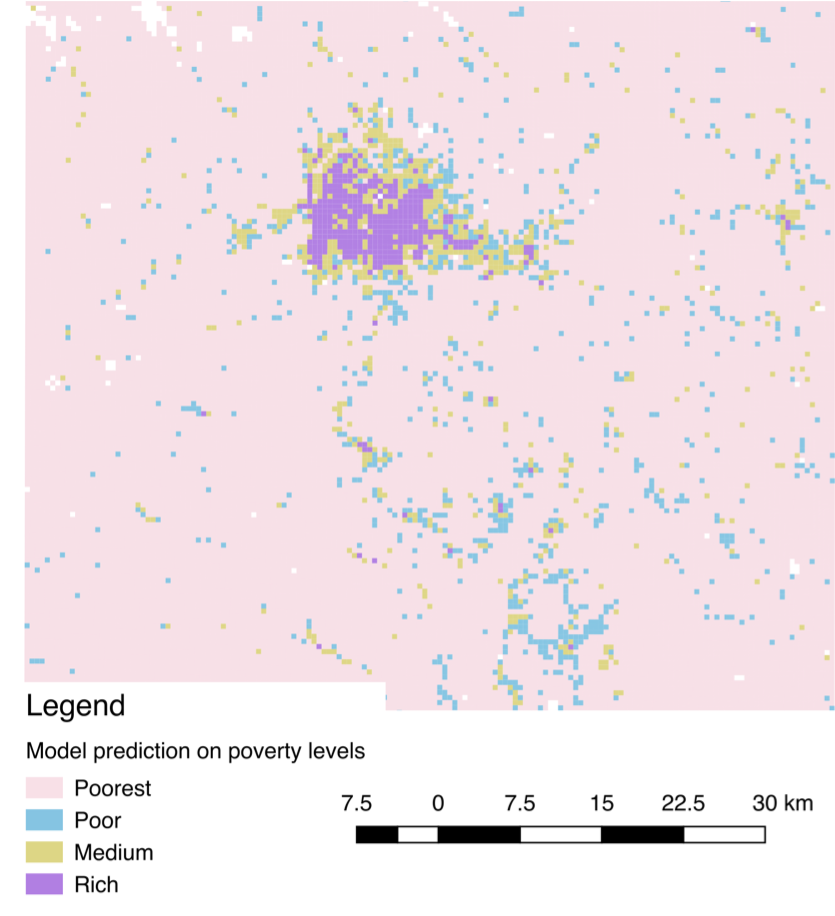

In [ ]:
# visualization from QGIS.
from IPython.display import Image
Image('figures/poverty_detection1.png')

#### Model performance

We loop through the `test` folder we created in training dataset that the model never see. 
We got F1 score of 0.74.

In [ ]:
def validate():

    parallel_model = load_model(op.join(ckpt_dir, pred_p['model_arch_fname']),
                                op.join(ckpt_dir, pred_p['model_weights_fname']))

    all_preds = list()
    with open(op.join(ckpt_dir, pred_p['model_params_fname']), 'r') as f_model_params:
        params_yaml = f_model_params.read()
        model_params = yaml.load(params_yaml)
    print('\n' + "=" * 40)
    print('Loaded model: {}\n\twith params: {}, gpus: {}'.format(
        pred_p['model_arch_fname'], pred_p['model_weights_fname'], pred_p['n_gpus']))


    ####################################################
    # Create filenames to process, exclude existing ones
    ####################################################
    pnd_dirs = ['test/average', 'test/poor', 'test/poorest', 'test/rich', 'test/richest']
    for png_dir in pnd_dirs:

        all_tile_fnames = os.listdir(op.join(root_dir, png_dir))
        all_tile_inds = [tile for tile in all_tile_fnames]


        print('\n{} tiles to predict on'.format(len(all_tile_inds)))

        print('{} tiles to predict on after set exclusion and file check'.format(len(all_tile_inds)))

        ###############################
        # Predict on batches of images
        ###############################
        y_preds = []
        pred_dict = dict()

        for tile_ind in all_tile_inds:

            ########################################
            # Load batch into memory
            ########################################
            img = np.array(Image.open(op.join(png_dir, tile_ind)))
            img = np.expand_dims(img, 0)

            ########################################
            # Preproc and predict on batch of images
            ########################################
            image_tensor = vgg16_preproc(img)


            y_p = parallel_model.predict(image_tensor, batch_size=1,
                                         verbose=0)

            y_true = png_dir.split('/')[-1]
            img_id = tile_ind
            comp = [img_id, y_true, customize_pred(y_p)]
            all_preds.append(comp)
    return all_preds

In [ ]:
final_t = validate()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [ ]:
classes=['poorest','poor',  'average', 'rich', 'richest']

In [ ]:
y_true=[true[1] for true in final_t]
y_pred = [pred[2] for pred in final_t]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

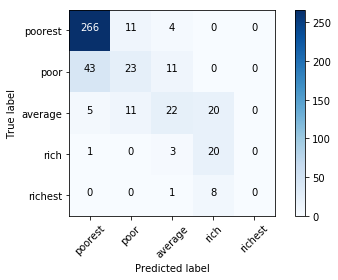

In [ ]:
cnf_matrix = confusion_matrix(y_true, y_pred,labels=classes)
plot_confusion_matrix(cnf_matrix, classes=classes)

In [ ]:
f1 = f1_score(y_true, y_pred, average='micro')
print("F1 score for poverty detection is: {0:.2f}".format(f1))

F1 score for poverty detection is: 0.74
